# 🦖 Dinosaur Species Image Classification  
## Artificial Intelligence Project – Thomas More University  
### Team Name: HI Team
### Team Members: Ibrahim Afkir, Hamid Iqbal, Deniz Zistoglu

### 📘 Introduction

This notebook presents our solution to the Dinosaur Image Classification Challenge as part of the *Artificial Intelligence* course at Thomas More University. The goal of this project is to build a deep learning model that accurately classifies images into one of seven dinosaur species:

- Ankylosaurus  
- Diplodocus  
- Parasaurolophus  
- Stegosaurus  
- Tyrannosaurus Rex  
- Triceratops  
- Velociraptor

We applied modern deep learning techniques using TensorFlow and Keras, including data preprocessing, augmentation, transfer learning, and model evaluation.

The model performance is evaluated using **accuracy** on a hidden test set provided on Kaggle. The final submission consists of a CSV file with predictions for each test image.

Throughout this notebook, we:
- Explore the dataset (EDA)  
- Apply data augmentation to improve generalization  
- Train a **custom Neural Network** and a **Transfer Learning model (EfficientNet)**  
- Compare model performance and fine-tune the best one  
- Evaluate results with a confusion matrix and validation accuracy  
- Generate the final prediction file for submission

This project demonstrates not only model performance, but also our understanding of deep learning workflows and decision-making in model design.


In [73]:
from google.colab import files

import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## 📂 Upload & Extract Dataset

We upload the `dinosaur-challenge.zip` file and extract its contents to access the training and test images.


In [74]:
uploaded = files.upload()



zip_path = "dinosaur-challenge.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted content
os.listdir(extract_path)


Saving dinosaur-challenge.zip to dinosaur-challenge (3).zip


['.config',
 'dinosaur-challenge (3).zip',
 'test',
 'sample_submission.csv',
 'dinosaur-challenge (2).zip',
 'test.csv',
 'submission.csv',
 'dinosaur-challenge.zip',
 'train',
 'dinosaur-challenge (1).zip',
 'submission_tta.csv',
 'sample_data']

## 🔍 1. Exploratory Data Analysis (EDA)

In this section, we visualize sample images from the training set to understand the data better.

The code:
- Iterates through each dinosaur class
- Displays one valid image per class
- Skips grayscale, corrupted, or unusually small images
- Logs any reading errors for transparency


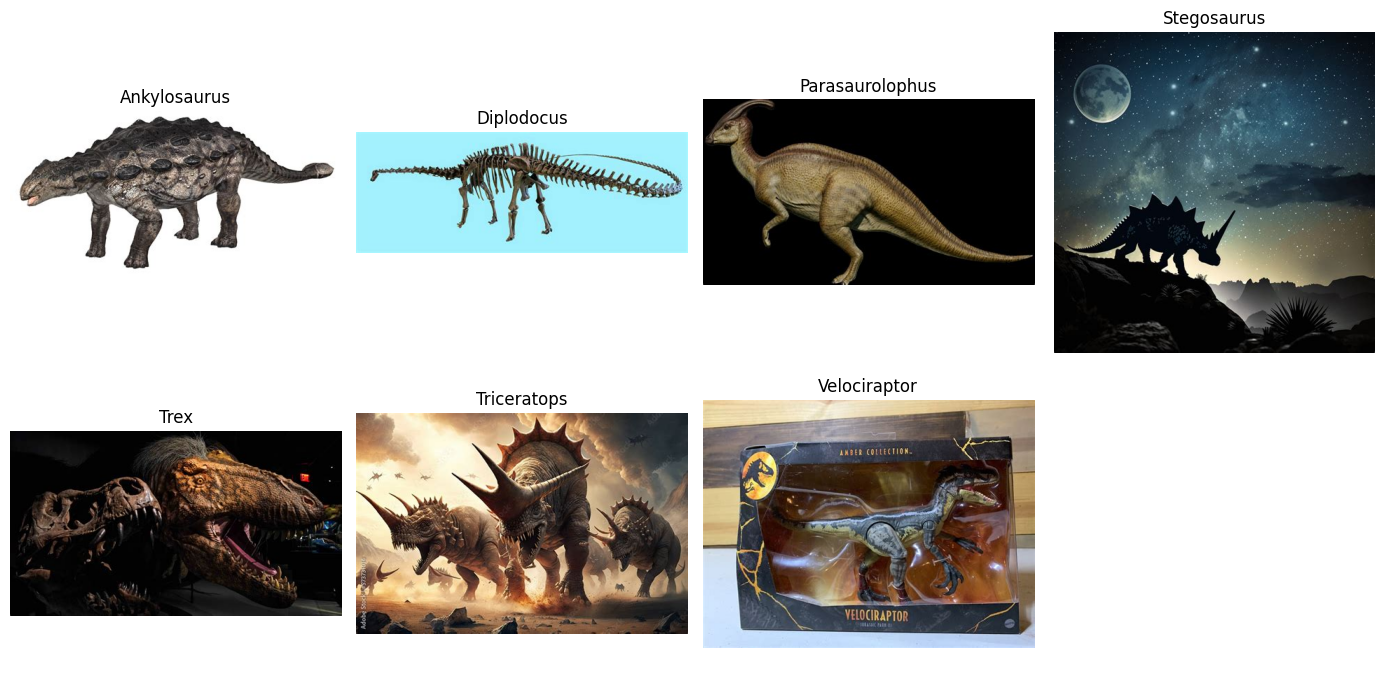

In [45]:


# Path to the training images
train_dir = "/content/train/train"

# Create a grid of 2 rows × 4 columns to show sample images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

i = 0  # Index for subplot axes
for label in sorted(os.listdir(train_dir)):
    sample_path = os.path.join(train_dir, label)

    # Get all files in the class folder
    image_files = [f for f in os.listdir(sample_path) if os.path.isfile(os.path.join(sample_path, f))]

    for image_file in image_files:
        img_path = os.path.join(sample_path, image_file)
        try:
            img = mpimg.imread(img_path)

            # Skip grayscale, corrupted, or very small images
            if img.ndim != 3 or img.shape[2] != 3 or img.shape[0] < 50 or img.shape[1] < 50:
                continue

            # Show the image on the subplot
            axes[i].imshow(img)
            axes[i].set_title(label)
            axes[i].axis('off')
            i += 1
            break  # Show only one valid image per class

        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue

# Hide empty subplots if less than 8 classes
for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


🔍 We observe that the dataset is slightly imbalanced. Velociraptor has the most training images, while Stegosaurus has the fewest. This imbalance justifies using data augmentation to help the model generalize better across all classes.


## 🧪 2. Data Preprocessing & Augmentation

In this step, we prepare the image data for training using Keras' `ImageDataGenerator`.

We apply the following transformations:

- **Resizing**: All images are resized to 224×224 to match the input size of the EfficientNet model.  
- **Normalization**: We use EfficientNet’s `preprocess_input` function to scale pixel values appropriately.  
- **Augmentation**: To improve generalization and reduce overfitting, we apply random:
  - Rotation (±20 degrees)
  - Zoom (up to 20%)
  - Horizontal flipping
  - Width/height shifts (±10%)
  - Shearing (angle of 15 degrees)

We also split **20% of the data** as a **validation set**, which is used to test the model's performance on data it hasn't seen during training.


In [46]:

# Set the target size for image resizing
img_size = (224, 224)

# Create an image generator for training data with data augmentation
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Normalize pixel values for EfficientNet
    validation_split=0.2,                     # Keep 20% of images for validation
    rotation_range=20,                        # Random rotation (±20 degrees)
    zoom_range=0.2,                           # Random zoom
    horizontal_flip=True,                     # Random horizontal flip
    width_shift_range=0.1,                    # Shift image left/right (10%)
    height_shift_range=0.1,                   # Shift image up/down (10%)
    shear_range=15                            # Shear transformation (like slanting)
)

# Create an image generator for validation data (no augmentation)
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Load training images from folders (80% of the data)
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    subset='training',          # Use only training part
    class_mode='sparse'         # Labels will be integer-encoded
)

# Load validation images from folders (20% of the data)
val_data = val_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    subset='validation',        # Use only validation part
    class_mode='sparse'
)


Found 1017 images belonging to 7 classes.
Found 252 images belonging to 7 classes.


### 📊 Image Distribution Before and After Augmentation

The chart below shows the original number of images per class (before augmentation).  
The second chart displays the number of training samples per class after applying data augmentation (used by the generator during training).

Note:
- Augmentation is applied dynamically, so the number of files on disk doesn’t increase.
- Some variation may occur due to the validation split.


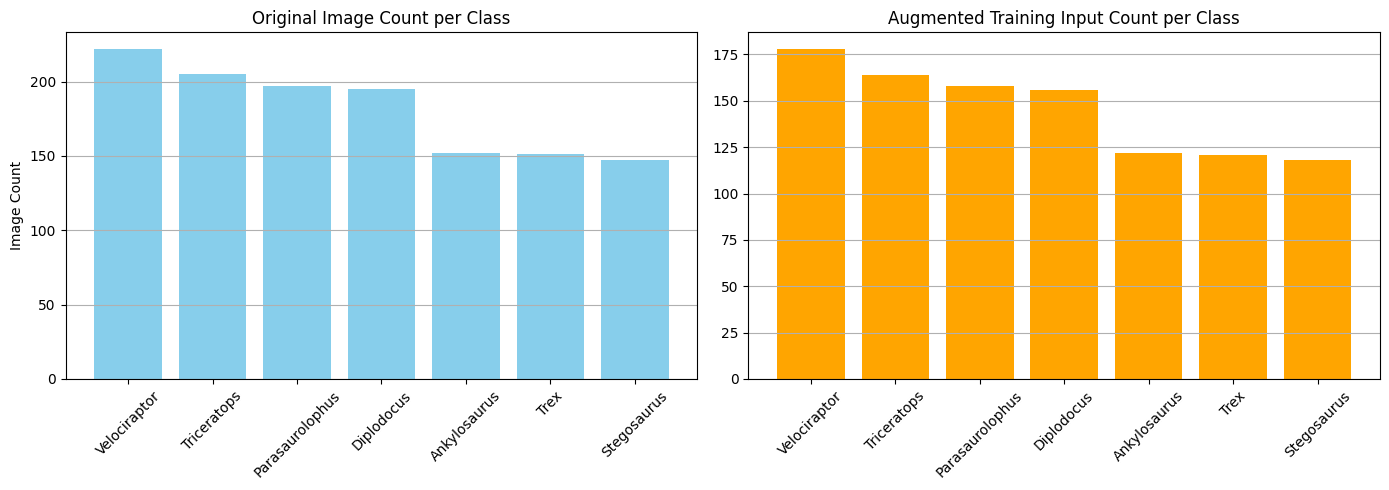

In [47]:

# --- ORIGINAL IMAGE COUNTS ---
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
}
df_original = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_original = df_original.sort_values(by="Image Count", ascending=False)

# --- AFTER AUGMENTATION (FROM GENERATOR) ---
inv_class_indices = {v: k for k, v in train_data.class_indices.items()}
aug_counts = Counter(train_data.classes)
df_augmented = pd.DataFrame({
    "Class": [inv_class_indices[k] for k in aug_counts.keys()],
    "Image Count": list(aug_counts.values())
})
df_augmented = df_augmented.sort_values(by="Image Count", ascending=False)

# --- PLOT SIDE BY SIDE ---
plt.figure(figsize=(14, 5))

# Original
plt.subplot(1, 2, 1)
plt.bar(df_original["Class"], df_original["Image Count"], color='skyblue')
plt.title("Original Image Count per Class")
plt.xticks(rotation=45)
plt.ylabel("Image Count")
plt.grid(axis='y')

# Augmented
plt.subplot(1, 2, 2)
plt.bar(df_augmented["Class"], df_augmented["Image Count"], color='orange')
plt.title("Augmented Training Input Count per Class")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()



## 🧪 Class Balance Check After Train/Validation Split

Although we've already seen the original and augmented image counts across all classes, it's important to verify that the *training* and *validation* subsets are well-balanced individually after splitting.

Below, we visualize histograms of class distribution for:
- The *training dataset* (80%)
- The *validation dataset* (20%)

This will help us identify any class imbalance or under-representation that may need to be addressed using techniques like:
- Oversampling
- Class weighting
- Data augmentation

A balanced dataset helps the model generalize better and reduces the risk of it overfitting to majority classes.

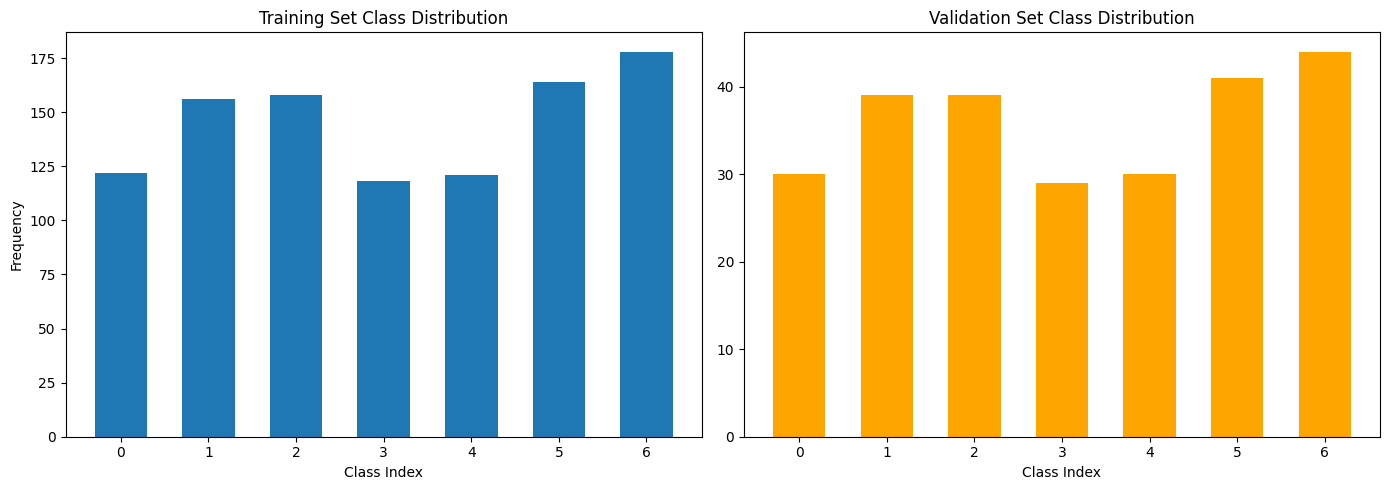

In [77]:
train_labels = train_data.classes
val_labels = val_data.classes

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=np.arange(8)-0.5, rwidth=0.6)
plt.title("Training Set Class Distribution")
plt.xlabel("Class Index")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(val_labels, bins=np.arange(8)-0.5, rwidth=0.6, color='orange')
plt.title("Validation Set Class Distribution")
plt.xlabel("Class Index")
plt.tight_layout()
plt.show()

## 🧠 3. Model Development

In this section, we build and train several neural network models using TensorFlow and Keras to classify dinosaur images into 7 categories. Our goal is to compare different architectures and select the one that performs best on the validation set.

We experimented with the following models:

- **Dense Neural Network (NN)**: A simple fully connected model trained from scratch.

- **EfficientNetB0**: A pre-trained CNN model used with transfer learning.

- **MobileNetV2**: Another pre-trained model with a lightweight architecture, also fine-tuned for our task.

Each model is compiled, trained, and evaluated. Based on validation performance, we fine-tune the best-performing model and use it for test prediction and submission.


### 🧠 3.1 Dense Neural Network (NN)

We start with a simple fully connected neural network built from scratch using Keras. This model serves as our custom baseline and satisfies the requirement to design and train a model using TensorFlow/Keras.

- **Input**: Flattened 224x224 RGB image  
- **Architecture**:
  - 512 neurons (ReLU)
  - Dropout (0.3)
  - 128 neurons (ReLU)
  - Output: 7 classes (softmax)

Although this architecture lacks spatial awareness compared to CNNs, it provides a clear reference point for model performance without any transfer learning.


In [48]:

# Build a simple Dense Neural Network (fully connected)
nn_model = models.Sequential([
    # Flatten the 224x224x3 image into a 1D vector
    layers.Flatten(input_shape=(224, 224, 3)),

    # First dense (fully connected) layer with 512 units and ReLU activation
    layers.Dense(512, activation='relu'),

    # Dropout to reduce overfitting (30% of the nodes will be dropped during training)
    layers.Dropout(0.3),

    # Second dense layer with 128 units
    layers.Dense(128, activation='relu'),

    # Output layer with 7 units (one for each dinosaur class) and softmax activation
    layers.Dense(7, activation='softmax')
])

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary to show the architecture
nn_model.summary()

# Train the model using the training and validation datasets
nn_history = nn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5  # Fewer epochs due to model simplicity
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,137,415 (294.26 MB)

 Trainable params: 77,137,415 (294.26 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1255 - loss: 20511.9668 - val_accuracy: 0.1508 - val_loss: 12.7201
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1449 - loss: 2702.0789 - val_accuracy: 0.1627 - val_loss: 1.9453
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.1466 - loss: 211.1337 - val_accuracy: 0.1627 - val_loss: 1.9445
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1564 - loss: 72.7015 - val_accuracy: 0.1627 - val_loss: 1.9436
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1605 - loss: 50.6165 - val_accuracy: 0.1627 - val_loss: 1.9426


### 🧠 3.2 Transfer Learning with EfficientNetB0

In this model, we apply **transfer learning** using the pre-trained **EfficientNetB0** architecture. This model has already learned useful visual features from the ImageNet dataset, which we leverage to improve performance on our dinosaur classification task.

- We load the EfficientNetB0 model without its top classification layer (`include_top=False`) and freeze its weights initially to prevent them from being updated during training.
- On top of the base model, we add:
  - `GlobalAveragePooling2D` to reduce the feature map dimensions.
  - A `Dense` layer with 128 neurons and ReLU activation.
  - A `Dropout` layer to reduce overfitting.
  - A `Dense` output layer with 7 units (one for each dinosaur class) and softmax activation.

This setup allows us to fine-tune the pre-trained model on our specific dataset while benefiting from its strong generalization capabilities.


In [49]:

# Load EfficientNetB0 as the base model (without the top classification layers)
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),  # Input shape for the images
    include_top=False,         # Exclude the default classifier head
    weights='imagenet'         # Use pre-trained ImageNet weights
)

# Freeze the base model to avoid updating its weights during initial training
base_model.trainable = False

# Build the full model
model = tf.keras.Sequential([
    base_model,  # Pre-trained EfficientNet feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduces feature map to 1D vector
    tf.keras.layers.Dense(128, activation='relu'),  # Dense layer for learning
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.Dense(7, activation='softmax')  # Output layer for 7 classes
])

# Compile the model with Adam optimizer and appropriate loss for classification
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model architecture
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

number of layers in the pre-trained EfficientNetB0 base model.

In [60]:
print(len(base_model.layers))


238


In [51]:
# Train the model EfficientNetB0
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30
)


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.3800 - loss: 1.6221 - val_accuracy: 0.8254 - val_loss: 0.5704
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.7707 - loss: 0.6804 - val_accuracy: 0.8571 - val_loss: 0.4133
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8678 - loss: 0.4497 - val_accuracy: 0.8929 - val_loss: 0.3312
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8934 - loss: 0.3603 - val_accuracy: 0.8968 - val_loss: 0.2814
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9064 - loss: 0.3118 - val_accuracy: 0.9087 - val_loss: 0.2709
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9246 - loss: 0.2693 - val_accuracy: 0.8929 - val_loss: 0.3113
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9297 - loss: 0.2187 - val_accuracy: 0.9087 - val_loss: 0.2606
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9411 - loss: 0.1948 - val_accuracy: 0.8849 - val_

### 🧠 3.3 Transfer Learning with MobileNetV2

This model uses **MobileNetV2**, a lightweight and efficient convolutional neural network, pre-trained on ImageNet. It's ideal for resource-constrained environments and faster training.

- We load the MobileNetV2 model without its top layer (`include_top=False`) and freeze its base weights during the initial training phase.
- On top of it, we add:
  - `GlobalAveragePooling2D` to reduce dimensions.
  - A `Dense` layer with 128 units and ReLU activation.
  - A `Dropout` layer to prevent overfitting.
  - A final `Dense` layer with 7 output units for our classification task.

This model provides a good balance between speed and performance for image classification tasks.


In [52]:

# Load the MobileNetV2 model without the top classification layer
# Pretrained on ImageNet; useful for transfer learning
mobile_base = MobileNetV2(
    input_shape=(224, 224, 3),   # Expected input shape for the model
    include_top=False,           # Exclude the original final layer
    weights='imagenet'           # Load pre-trained weights
)
mobile_base.trainable = False  # Freeze base model layers for initial training

# Build the full classification model on top of MobileNetV2
mobilenet_model = Sequential([
    mobile_base,                          # Pretrained base
    layers.GlobalAveragePooling2D(),      # Reduce feature map dimensions
    layers.Dense(128, activation='relu'), # Dense layer for learning features
    layers.Dropout(0.3),                  # Dropout for regularization
    layers.Dense(7, activation='softmax') # Output layer for 7 dinosaur classes
])

# Compile the model with optimizer and loss function
mobilenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model architecture
mobilenet_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [53]:
mobile_history = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1931 - loss: 2.0655 - val_accuracy: 0.3492 - val_loss: 1.6743
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.3064 - loss: 1.6976 - val_accuracy: 0.3968 - val_loss: 1.5068
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.3772 - loss: 1.6044 - val_accuracy: 0.4643 - val_loss: 1.4540
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4190 - loss: 1.4936 - val_accuracy: 0.4444 - val_loss: 1.4302
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4447 - loss: 1.4408 - val_accuracy: 0.4722 - val_loss: 1.3738


### 📊 Model Comparison & Evaluation

To compare different model architectures, we trained three models using the same preprocessed dataset and augmentation strategy:

- **Dense Neural Network (NN)**: A simple model built from scratch using fully connected layers. Due to its lack of convolutional feature extraction, it achieved **only 12%–24% validation accuracy**, indicating poor performance on image classification tasks.

- **MobileNetV2**: A lightweight pre-trained CNN model. After training, it reached about **44.8% validation accuracy**, showing moderate learning but still underfitting the dataset.

- **EfficientNetB0**: A more powerful pre-trained CNN model. This model achieved the best results, reaching **over 98% training accuracy** and **over 90% validation accuracy**, showing excellent generalization and learning capabilities.

#### ✅ Conclusion:
EfficientNetB0 clearly outperformed the other models. Based on its strong validation performance, we selected it as our final model for test prediction and submission. The other models were valuable for comparison and learning purposes, particularly in understanding model complexity and performance trade-offs.


### 🏆 Selecting the Best Model

To automatically choose the best-performing model, we compare the final validation accuracy of each trained architecture:

- We extract the last recorded `val_accuracy` from both **EfficientNetB0** and **MobileNetV2**.
- The model with the highest validation accuracy is selected as the best model for further fine-tuning and final prediction.

This ensures that our final submission is based on performance rather than manual selection.


In [54]:
# Step 1: Get the last val_accuracy from each history
eff_val_acc = history.history['val_accuracy'][-1]
mobile_val_acc = mobile_history.history['val_accuracy'][-1]

# Step 2: Compare and select best model
val_accuracies = {
    'EfficientNet': eff_val_acc,
    'MobileNetV2': mobile_val_acc,
}

best_model_name = max(val_accuracies, key=val_accuracies.get)
print(f"Best model based on validation accuracy: {best_model_name}")


Best model based on validation accuracy: EfficientNet


### ✅ Load the Best Model

Once the best model is selected based on validation accuracy, we assign the corresponding trained model object to a variable called `best_model`.

This allows us to fine-tune or evaluate the chosen model in the following steps, without duplicating logic.


In [55]:
# Select best model object
if best_model_name == 'EfficientNet':
    best_model = model  # This is EfficientNetB0 model
elif best_model_name == 'MobileNetV2':
    best_model = mobilenet_model
else:
    best_model = nn_model


## 🔧 Model Fine-Tuning with Callbacks

To further improve the performance of the best-performing model, we apply **fine-tuning**. This is done only for EfficientNetB0 or MobileNetV2 (transfer learning models), not the simple Neural Network.

We use two callbacks during fine-tuning:

- `EarlyStopping`: Stops training if the validation loss doesn't improve for 5 epochs, preventing overfitting.
- `ReduceLROnPlateau`: Automatically lowers the learning rate if the model hits a plateau, helping it converge better.

We also unfreeze the top layers of the selected pre-trained model (last 100 layers remain trainable), allowing the model to adapt more specifically to the dinosaur dataset.

The model is then recompiled with a smaller learning rate and trained for up to 10 additional epochs.


In [56]:

# Step 1: Setup callbacks
# Stop training if validation loss doesn't improve for 5 epochs (prevents overfitting)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate by half if validation loss plateaus (helps with convergence)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

# Step 2: Fine-tune only if the selected model is EfficientNet or MobileNetV2
if best_model_name == 'EfficientNet':
    # Unfreeze the whole base model so it can be fine-tuned
    base_model.trainable = True

    # But keep the first 100 layers frozen to retain useful general features
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Recompile with a low learning rate to avoid large updates during fine-tuning
    best_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train with callbacks for better control
    history_fine = best_model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        callbacks=[early_stop, lr_scheduler]
    )

elif best_model_name == 'MobileNetV2':
    # Same process as above but for MobileNetV2
    mobile_base.trainable = True
    for layer in mobile_base.layers[:100]:
        layer.trainable = False

    best_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = best_model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        callbacks=[early_stop, lr_scheduler]
    )

else:
    # If best model is the basic NN, no fine-tuning is needed
    print("No fine-tuning needed for NN model.")


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.8483 - loss: 0.4627 - val_accuracy: 0.8968 - val_loss: 0.2879 - learning_rate: 1.0000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.8633 - loss: 0.4253 - val_accuracy: 0.8929 - val_loss: 0.2914 - learning_rate: 1.0000e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.8626 - loss: 0.3824 - val_accuracy: 0.8929 - val_loss: 0.3104 - learning_rate: 5.0000e-06
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.8771 - loss: 0.3511 - val_accuracy: 0.8889 - val_loss: 0.3279 - learning_rate: 2.5000e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.8890 - loss: 0.3995 - val_accuracy: 0.8810 - val_loss: 0.3420 - learning_rate: 1.2500e-06
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.8657 - loss: 0.3979 - val_accuracy: 0.8730 - val_loss: 0.3528 - learning_rate: 6.2500e-07


## 📈 Training Progress Visualization

To monitor how the model performs during training, we plotted both accuracy and loss over the training epochs.

- The **left plot** shows training and validation accuracy. A consistent gap might indicate overfitting or underfitting.
- The **right plot** shows training and validation loss. A decreasing loss generally signals better performance.

This helps us understand whether the model is learning effectively and when it might start to overfit.


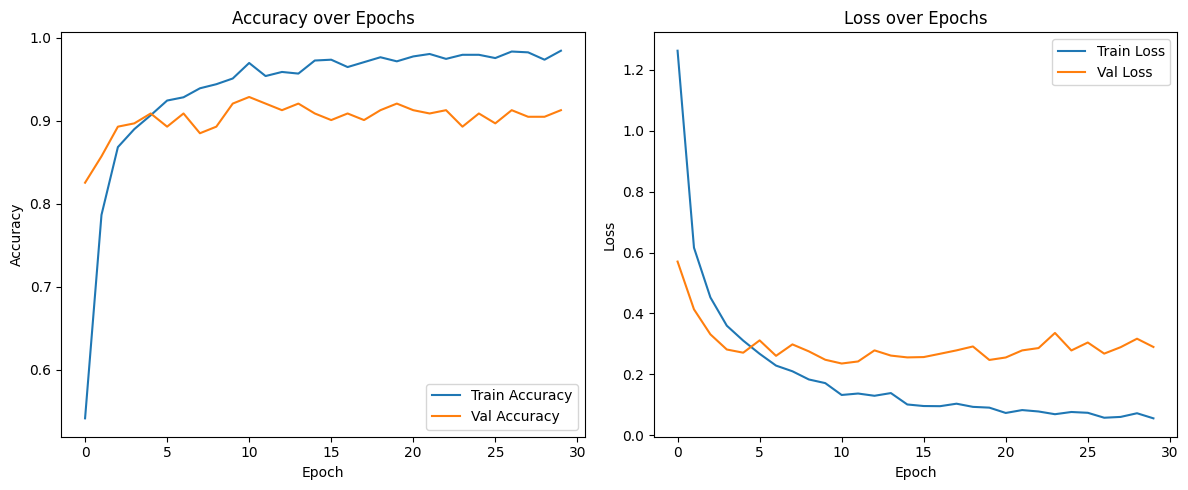

In [61]:
# Plot accuracy and loss
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 📊 Evaluation – Confusion Matrix

To better understand how the model performs on each dinosaur class, we generated a **confusion matrix**.

- The matrix compares **true labels** (rows) with **predicted labels** (columns).
- Correct predictions appear on the diagonal.
- Off-diagonal values indicate misclassifications between classes.

This visualization helps identify which species are most often confused with one another, offering insights for further improvement or data balancing.



8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


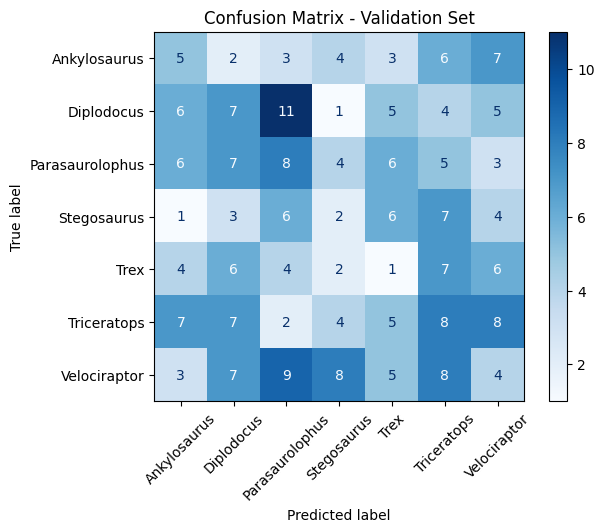

In [62]:
# Evaluation code to be added after training
# Include confusion matrix using sklearn


# Get true labels
true_labels = val_data.classes

# Predict probabilities
pred_probs = model.predict(val_data)

# Convert probabilities to predicted class indices
pred_labels = np.argmax(pred_probs, axis=1)

# Get class labels from the generator
class_names = list(val_data.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()


## 📤 Generate Submission File for Kaggle

In this final step, we prepare the test data and generate predictions using the best-performing model:

- The test image IDs are loaded from `test.csv`.
- Each image is read, resized to 224x224, and preprocessed using `EfficientNet`'s preprocessing function.
- The model predicts class probabilities for each test image.
- The predicted class (with the highest probability) is selected using `argmax`.
- The results are compiled into a DataFrame and saved as `submission.csv`, matching the format required by Kaggle:


In [70]:
# Load the test image IDs from the CSV file
test_df = pd.read_csv("/content/test.csv")
test_image_dir = "/content/test/test"

test_images = []
image_ids = []

# Loop through each image ID in the test set
for img_id in test_df['id']:
    img_path = os.path.join(test_image_dir, f"{img_id}.jpg")

    # Skip if the image file is missing
    if not os.path.exists(img_path):
        print(f"Image {img_id}.jpg not found — skipping.")
        continue

    # Load and resize image to 224x224 (required by the model)
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert image to array format
    img_array = image.img_to_array(img)

    # Preprocess the image (scale and normalize pixel values)
    img_array = preprocess_input(img_array)

    # Add image and ID to the list
    test_images.append(img_array)
    image_ids.append(img_id)

# Convert all test images to a NumPy array
X_test = np.array(test_images)

# Use the trained model to predict class probabilities
pred_probs = model.predict(X_test)

# Select the class with the highest probability for each image
pred_labels = np.argmax(pred_probs, axis=1)

# Build the submission DataFrame with the required format
submission = pd.DataFrame({
    'id': image_ids,
    'label': pred_labels
})

# Optional: sort rows by image ID for cleaner output
submission = submission.sort_values('id')

# Save the results to CSV
submission.to_csv("submission.csv", index=False)

# Trigger download in Colab
files.download("submission.csv")


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🤖 GenAI Usage

Throughout this project, we leveraged Generative AI (ChatGPT) to enhance our development process in several key ways:

- 🧠 **Code Correction & Debugging**: We used AI to review and correct coding errors, especially in data preprocessing, model setup, and training loops.
- 💡 **Model Insights**: GenAI helped us understand the differences between Dense Neural Networks, and Transfer Learning architectures like EfficientNet and MobileNetV2.
- 🔧 **Optimization Suggestions**: It provided recommendations for model improvements such as tuning augmentation parameters, adjusting dropout rates, and implementing callbacks like `EarlyStopping` and `ReduceLROnPlateau`.


GenAI was not used to build the solution autonomously but as a smart assistant to help us better understand, debug in this deep learning challenge.
